![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Manipulation in The Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/manipulation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

In this notebook, we'll walk through a couple manipulation environments available in MuJoCo Playground.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [ ]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Fri Apr 18 01:56:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| 54%   65C    P8             20W /  250W |      16MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%env MUJOCO_GL=egl

# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# # Graphics and plotting.
# print("Installing mediapy:")
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

env: MUJOCO_GL=egl


In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [ ]:
#@title Install MuJoCo Playground
!pip install playground

In [4]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry

# Manipulation

MuJoCo Playground contains several manipulation environments (all listed below after running the command).

In [4]:
registry.manipulation.ALL_ENVS

('AlohaHandOver',
 'AlohaSinglePegInsertion',
 'PandaPickCube',
 'PandaPickCubeOrientation',
 'PandaPickCubeCartesian',
 'PandaOpenCabinet',
 'PandaRobotiqPushCube',
 'LeapCubeReorient',
 'LeapCubeRotateZAxis')

# Franka Emika Panda

Let's start off with the simplest environment, simply picking up a cube with the Franka Emika Panda.

In [5]:
env_name = 'PandaPickCube'
# env_name = 'PandaOpenCabinet'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [6]:
env_cfg

action_repeat: 1
action_scale: 0.04
ctrl_dt: 0.02
episode_length: 150
reward_config:
  scales:
    box_target: 8.0
    gripper_box: 4.0
    no_floor_collision: 0.25
    robot_target_qpos: 0.3
sim_dt: 0.005

## Train Policy

Let's train the pick cube policy and visualize rollouts. The policy takes roughly 3 minutes to train on an RTX 4090.

In [9]:
from mujoco_playground.config import manipulation_params
ppo_params = manipulation_params.brax_ppo_config(env_name)
ppo_params.num_evals = 40
ppo_params

action_repeat: 1
batch_size: 512
discounting: 0.97
entropy_cost: 0.02
episode_length: 150
learning_rate: 0.001
network_factory:
  policy_hidden_layer_sizes: !!python/tuple
  - 32
  - 32
  - 32
  - 32
  policy_obs_key: state
  value_hidden_layer_sizes: !!python/tuple
  - 256
  - 256
  - 256
  - 256
  - 256
  value_obs_key: state
normalize_observations: true
num_envs: 2048
num_evals: 40
num_minibatches: 32
num_timesteps: 20000000
num_updates_per_batch: 8
reward_scaling: 1.0
unroll_length: 10

### PPO

In [ ]:
from pprint import pprint
from collections import defaultdict 
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


loss_data = defaultdict(list)

def progress(num_steps, metrics):
  clear_output(wait=True)

  pprint(metrics)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5*4, 3))
  
  axs[0].set_xlim([0, ppo_params["num_timesteps"] * 1.25])
  axs[0].set_xlabel("# environment steps")
  axs[0].set_ylabel("reward per episode")
  axs[0].set_title(f"y={y_data[-1]:.3f}")
  axs[0].errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  if "training/policy_loss" in metrics:
    
    loss_data["policy_loss"].append(metrics["training/policy_loss"])
    loss_data["v_loss"].append(metrics["training/v_loss"])
    loss_data["entropy_loss"].append(metrics["training/entropy_loss"])

    for i, (name, data) in enumerate(loss_data.items(), 1):
      axs[i].set_xlim([0, ppo_params["num_timesteps"] * 1.25])
      axs[i].set_xlabel("# environment steps")
      axs[i].set_ylabel(name)
      axs[i].plot(x_data[1:], data, color="blue")
      axs[i].set_title(f"y={data[-1]:.3e}")

  fig.tight_layout()
  display(fig)

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    # seed=1
    seed=42
)

{'eval/avg_episode_length': Array(149.18, dtype=float32),
 'eval/episode_box_target': Array(95.433, dtype=float32),
 'eval/episode_box_target_std': Array(29.473, dtype=float32),
 'eval/episode_gripper_box': Array(130.774, dtype=float32),
 'eval/episode_gripper_box_std': Array(13.517, dtype=float32),
 'eval/episode_no_floor_collision': Array(147.641, dtype=float32),
 'eval/episode_no_floor_collision_std': Array(10.856, dtype=float32),
 'eval/episode_out_of_bounds': Array(0.008, dtype=float32),
 'eval/episode_out_of_bounds_std': Array(0.088, dtype=float32),
 'eval/episode_reward': Array(1340.513, dtype=float32),
 'eval/episode_reward_std': Array(282.113, dtype=float32),
 'eval/episode_robot_target_qpos': Array(56.808, dtype=float32),
 'eval/episode_robot_target_qpos_std': Array(20.067, dtype=float32),
 'eval/epoch_eval_time': 0.8634188175201416,
 'eval/sps': 22237.18039310871,
 'eval/walltime': 65.5498628616333,
 'training/entropy_loss': Array(-0.038, dtype=float32),
 'training/policy_lo

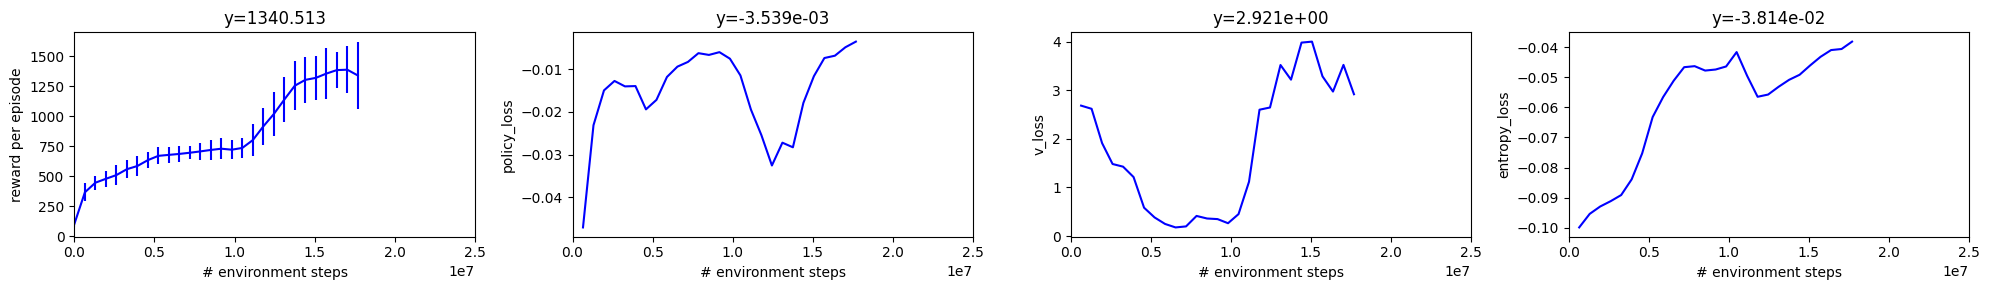

KeyboardInterrupt: 

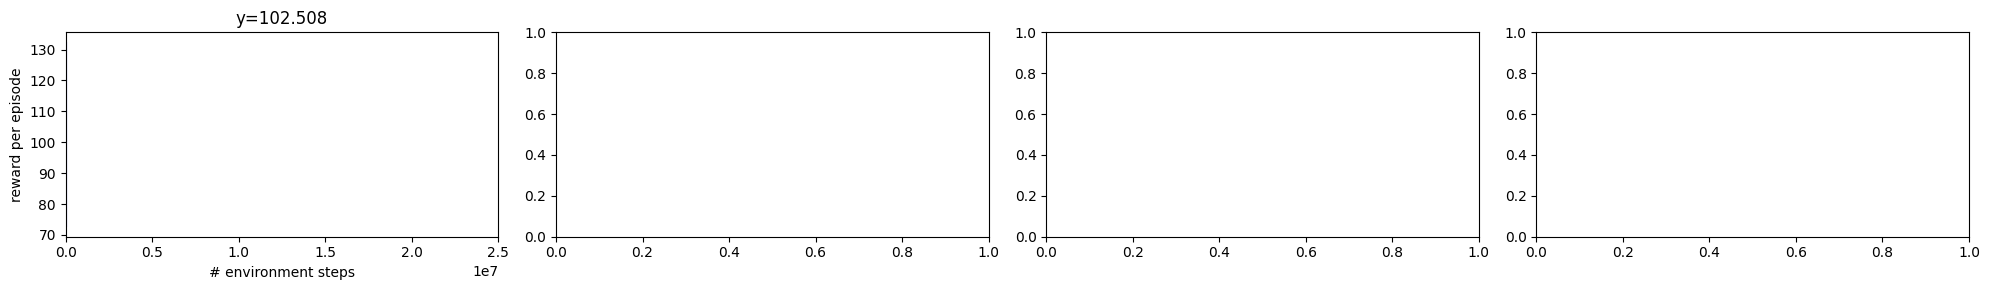

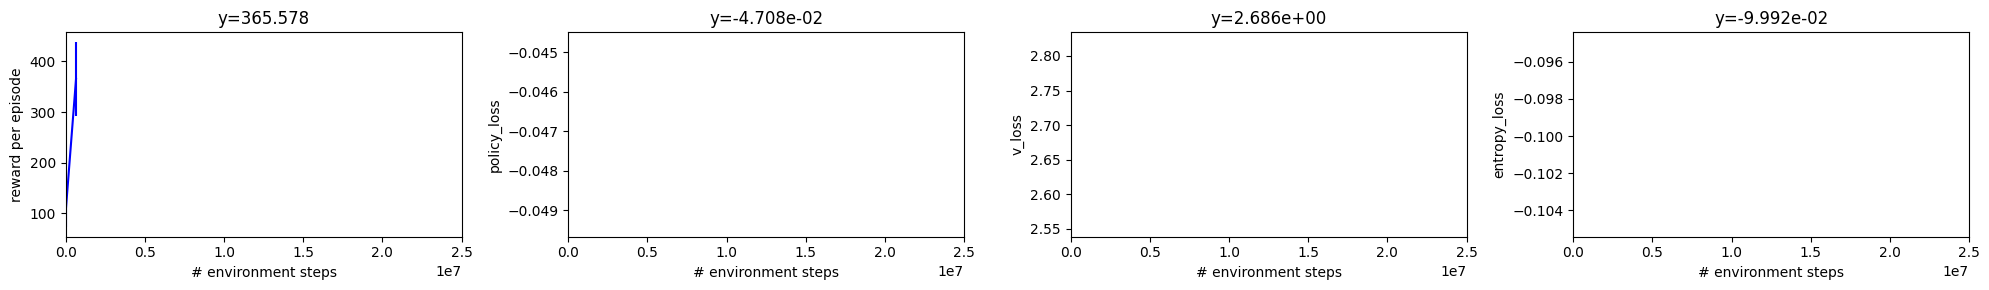

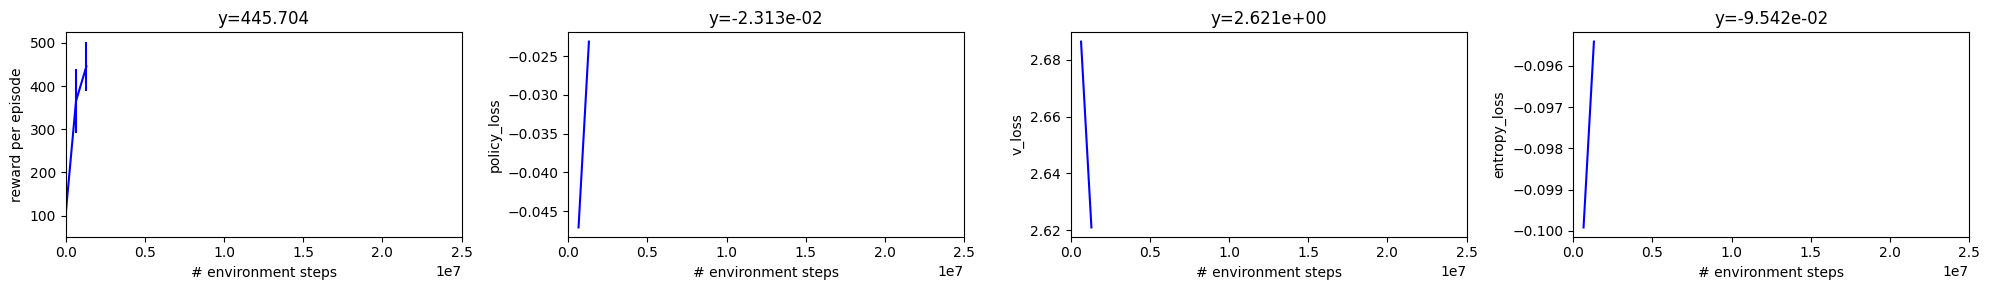

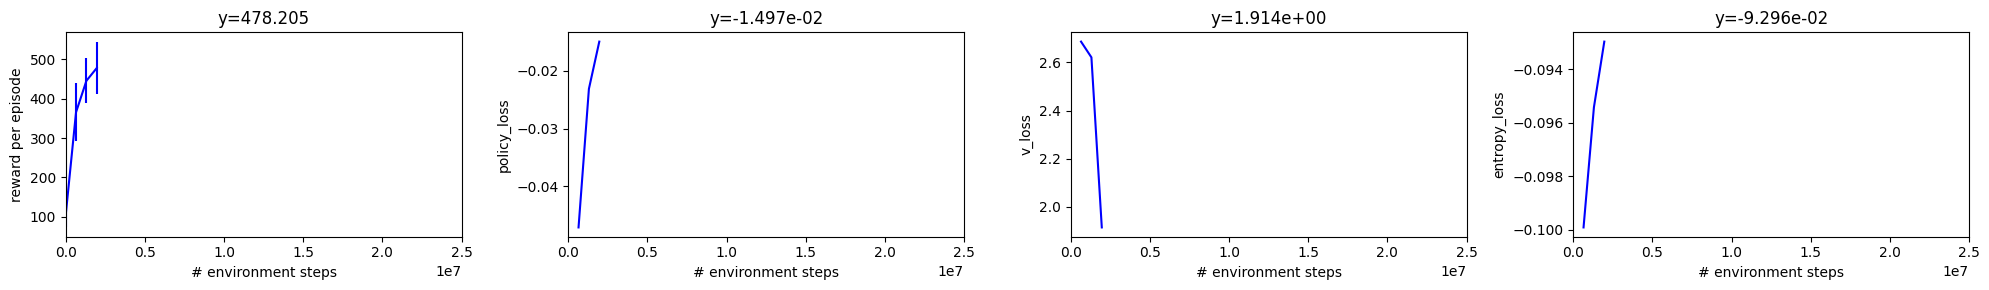

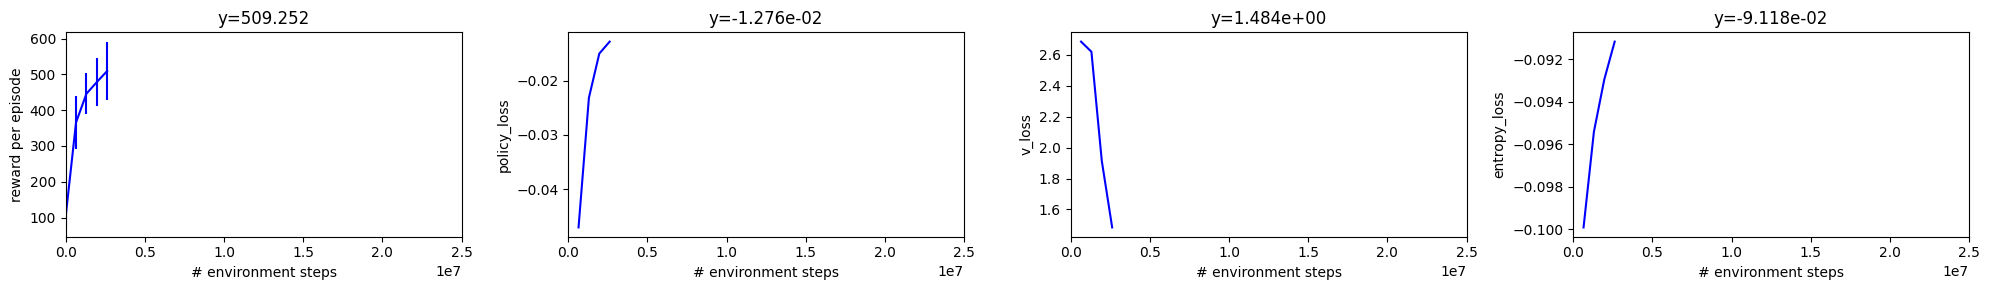

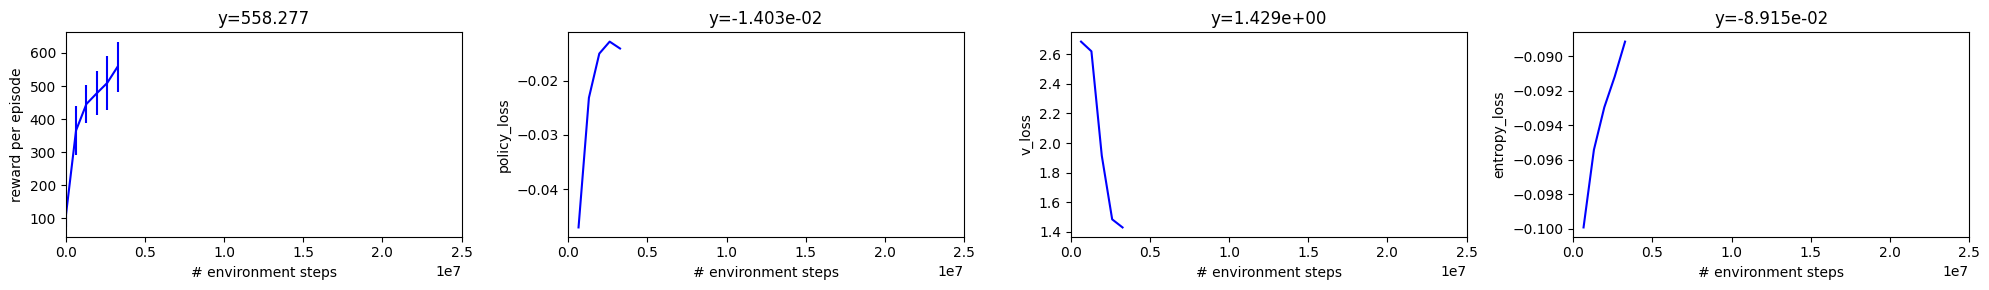

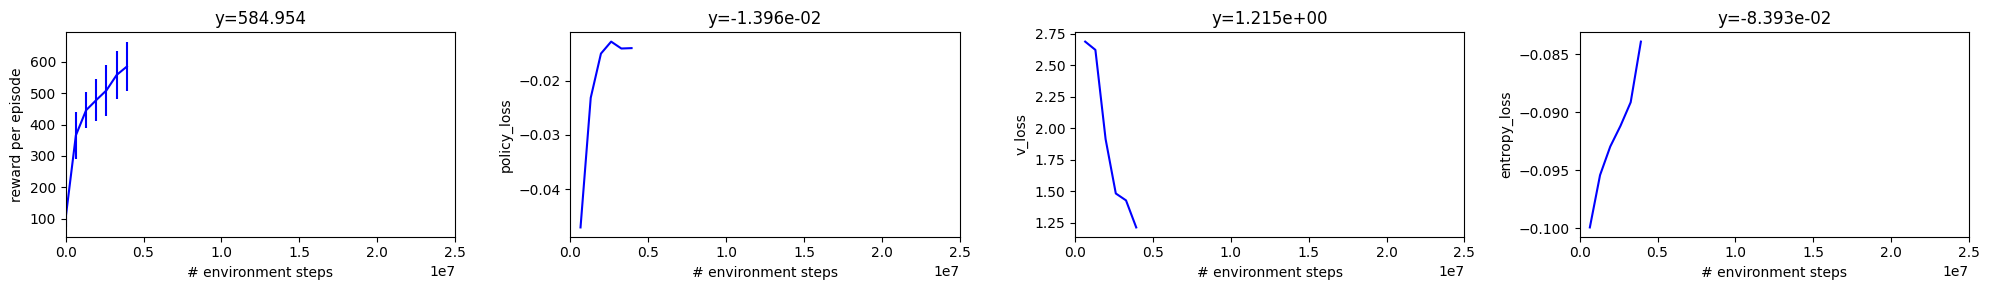

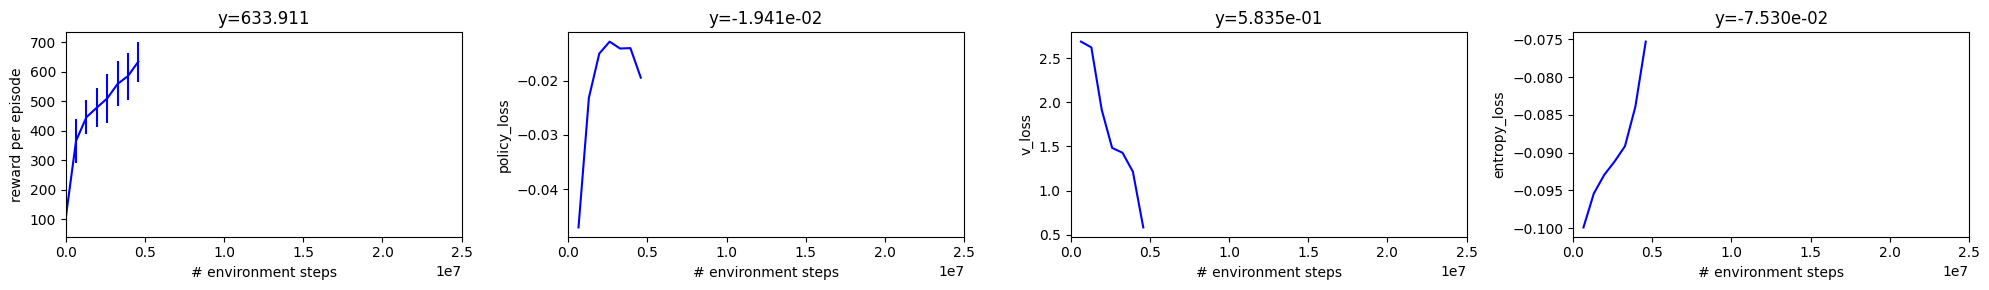

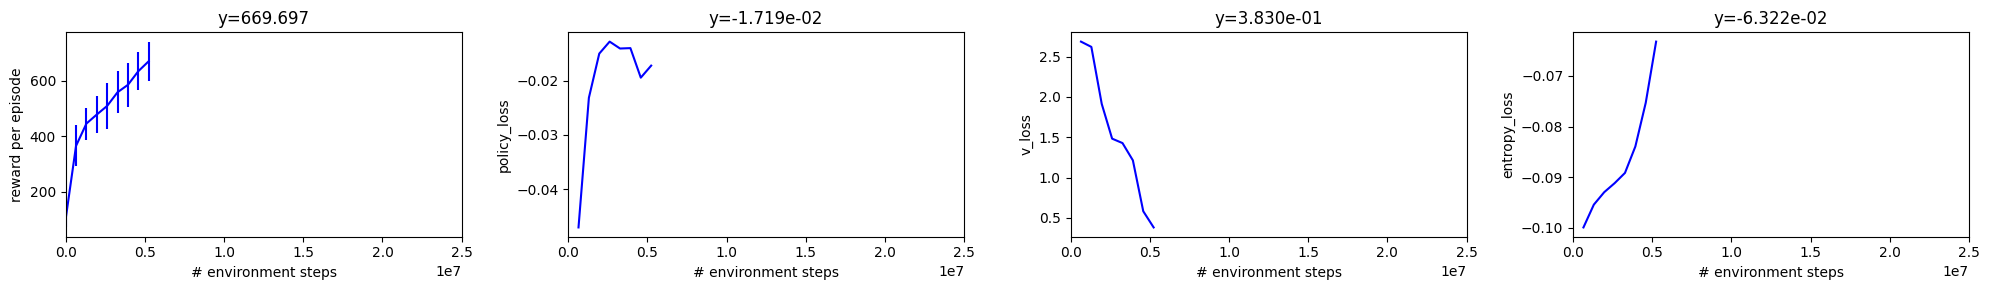

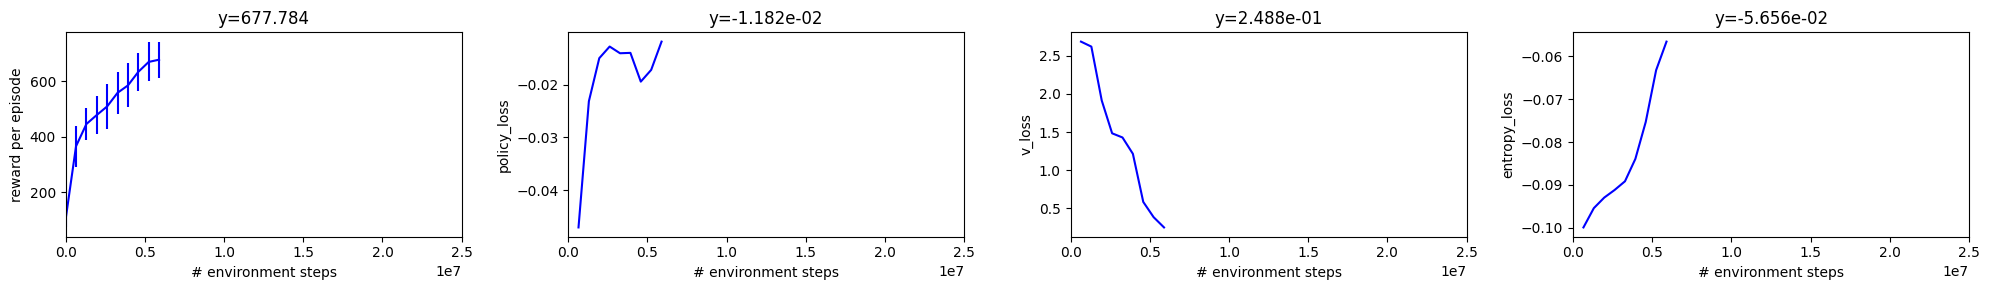

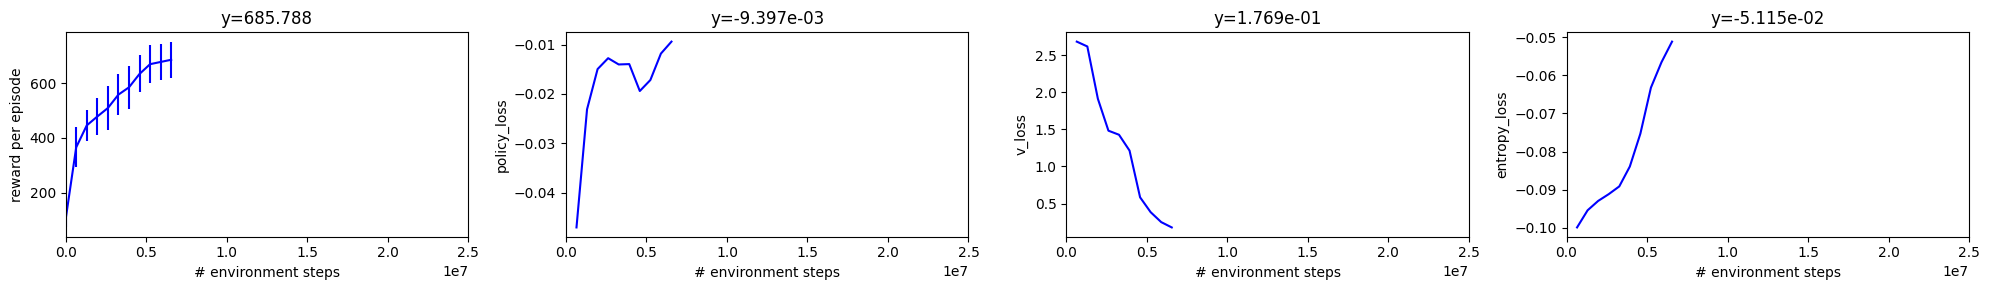

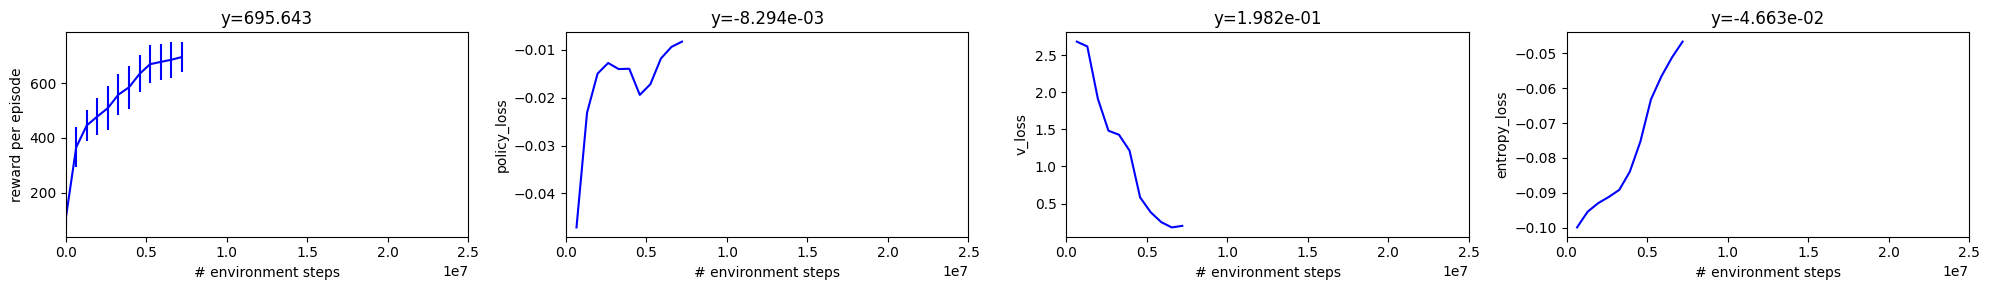

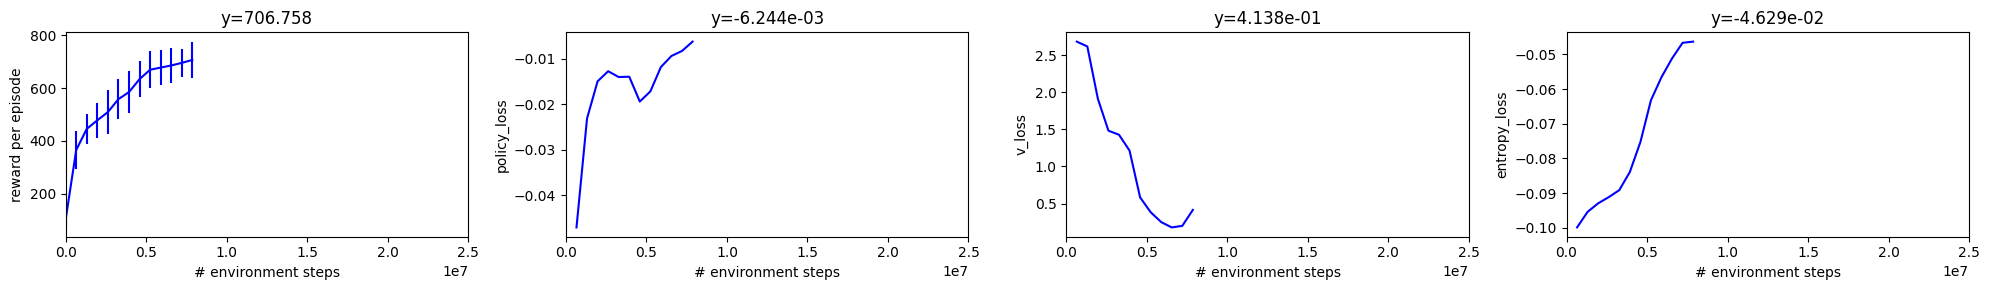

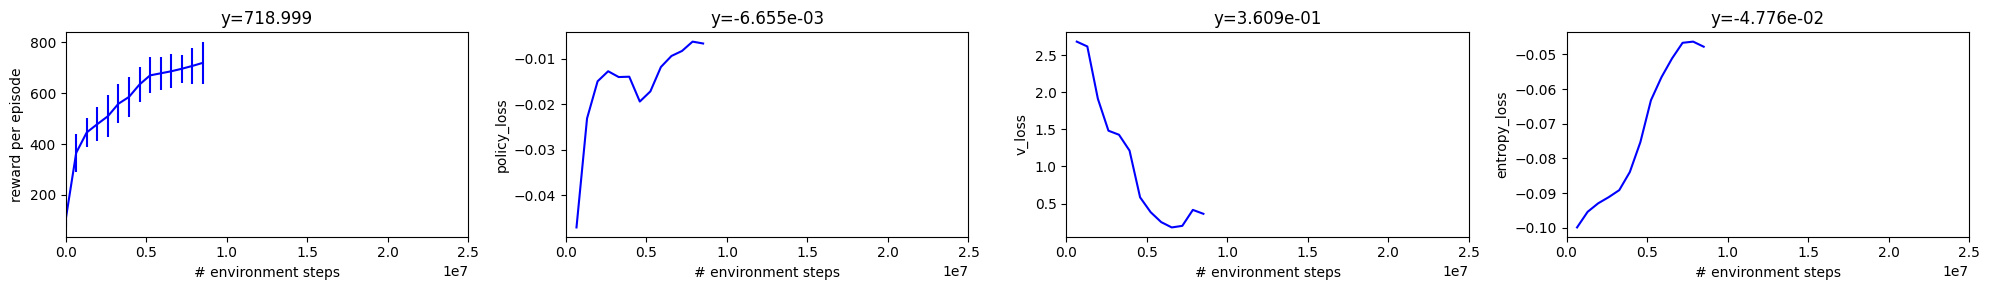

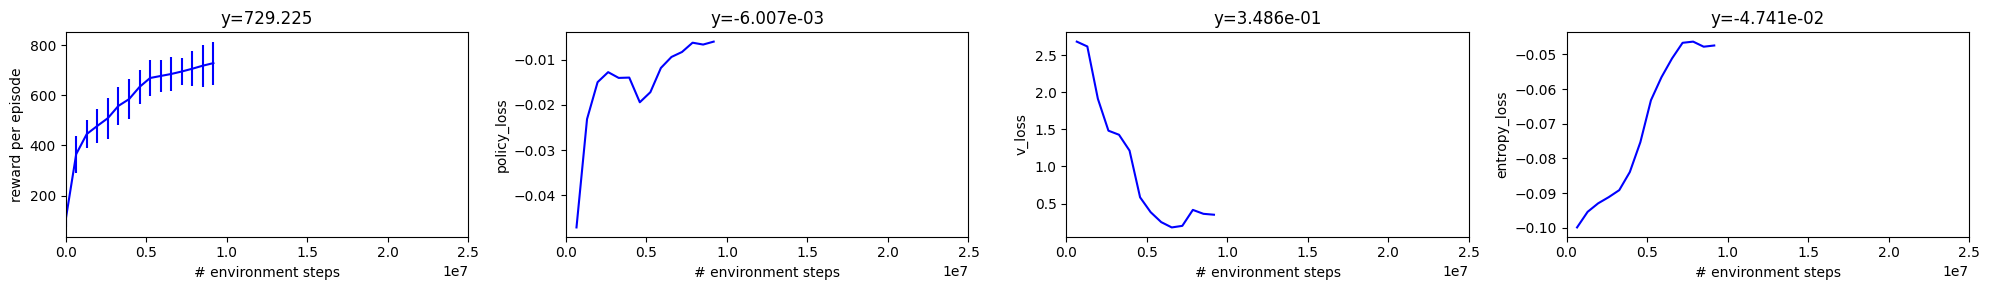

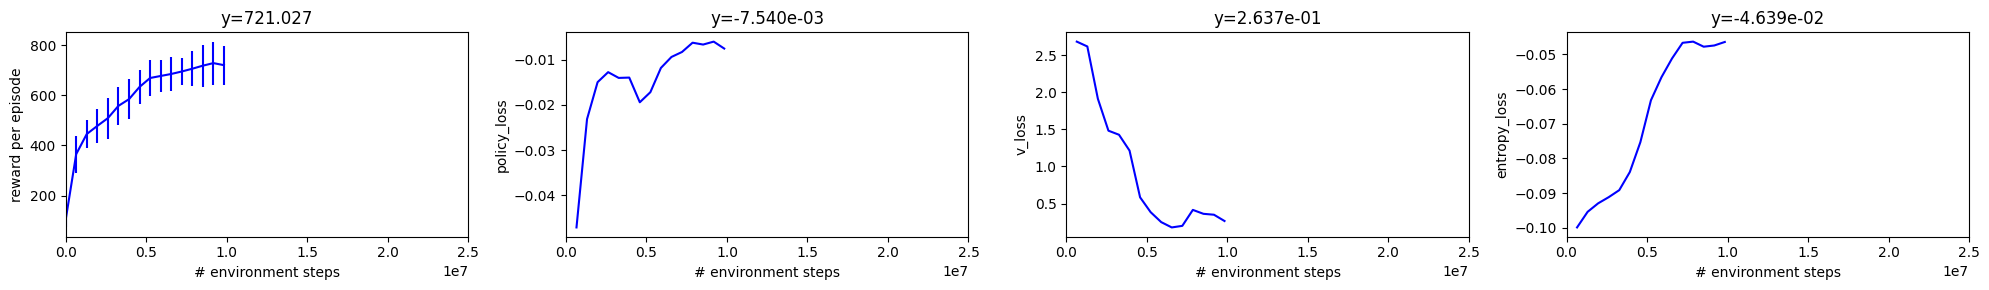

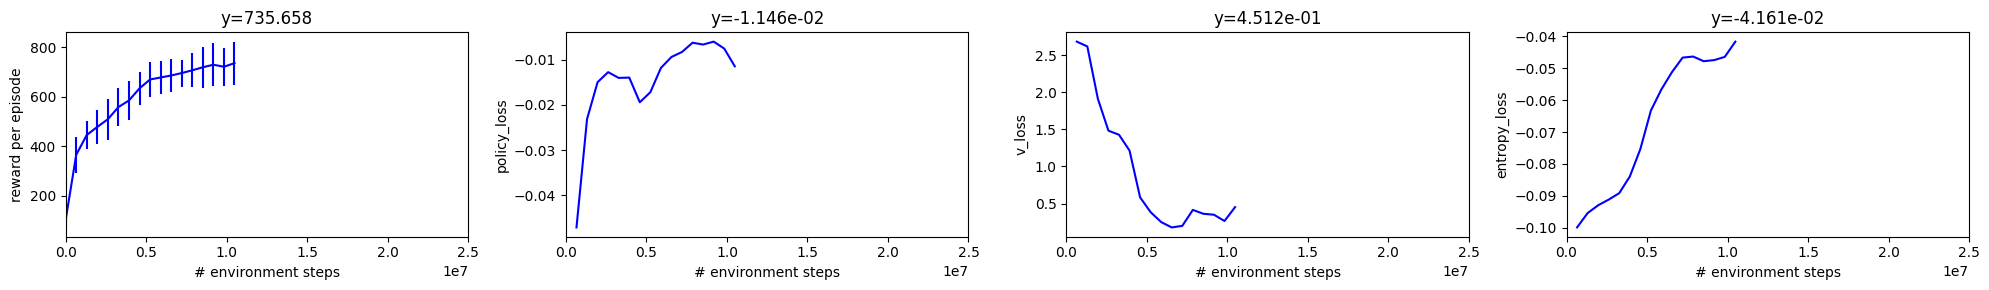

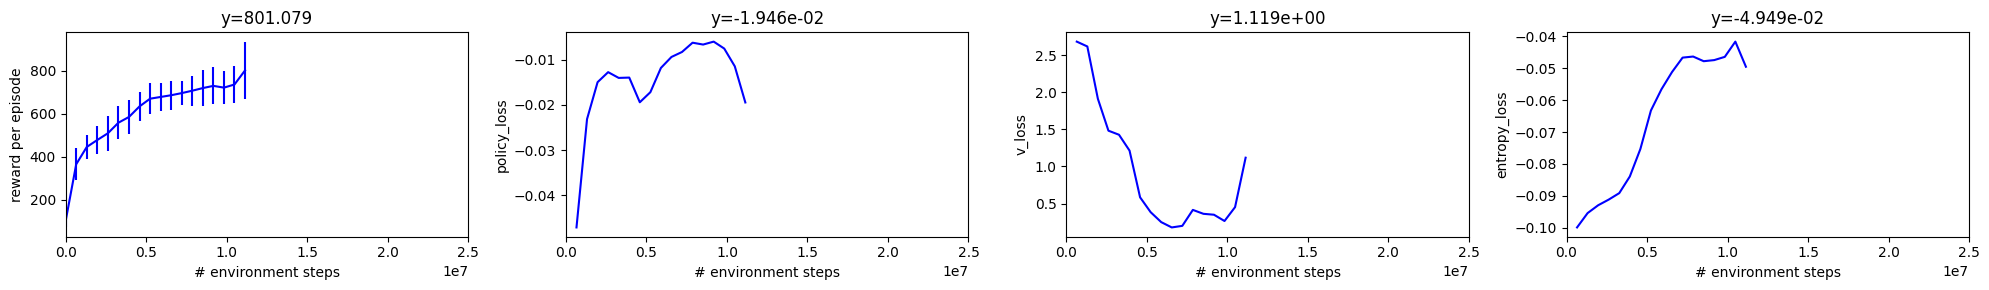

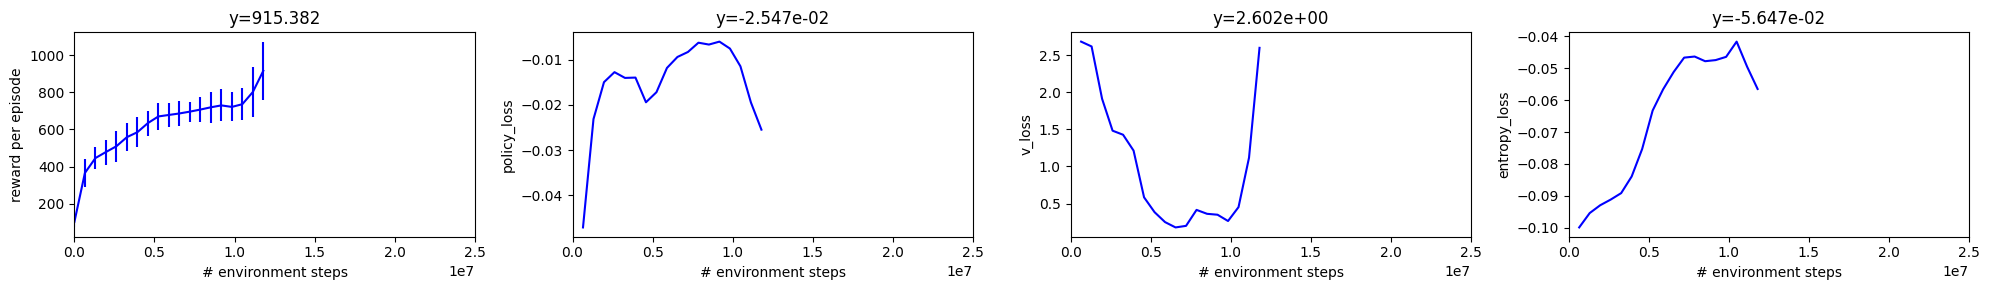

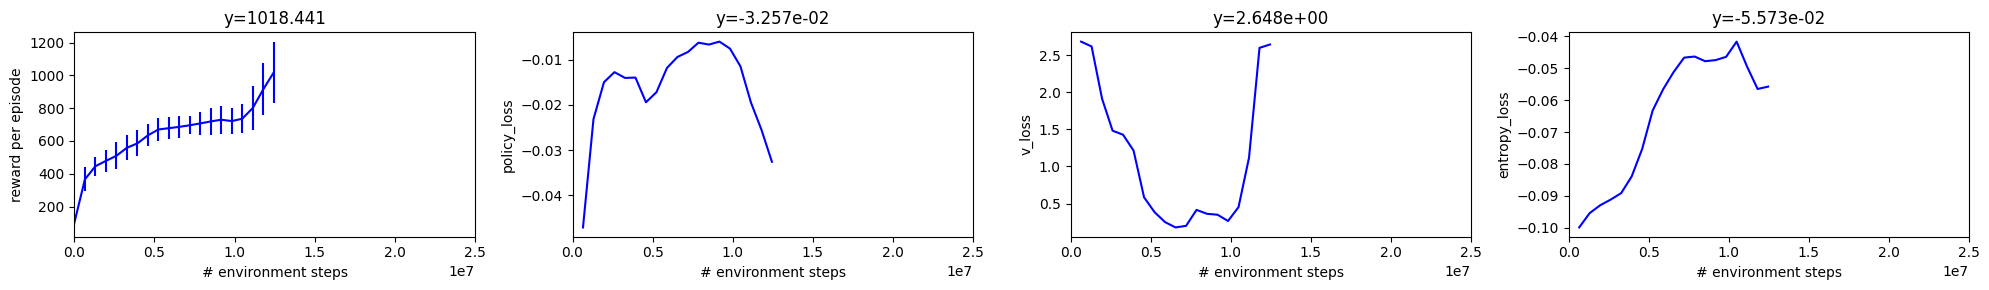

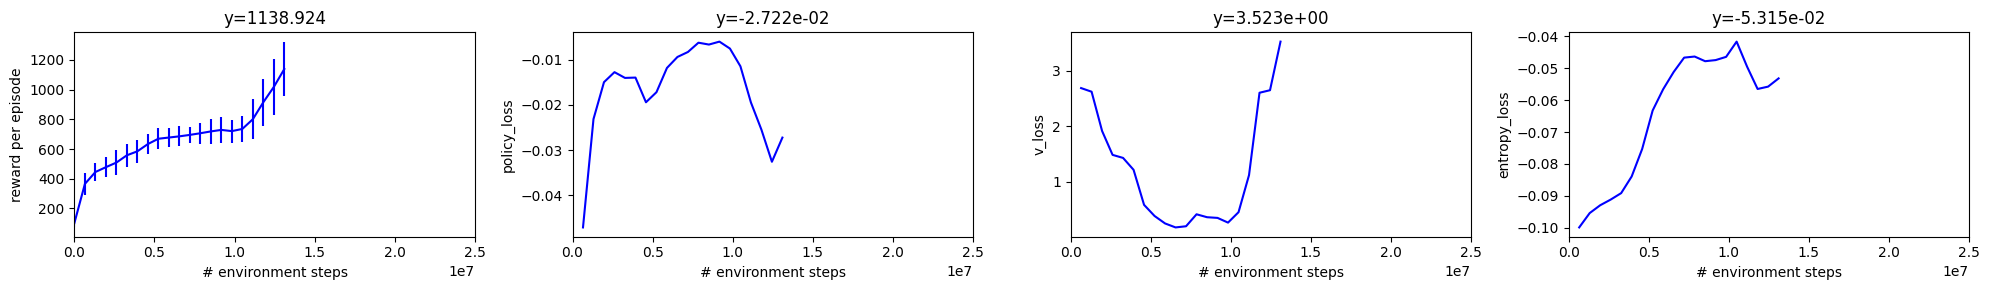

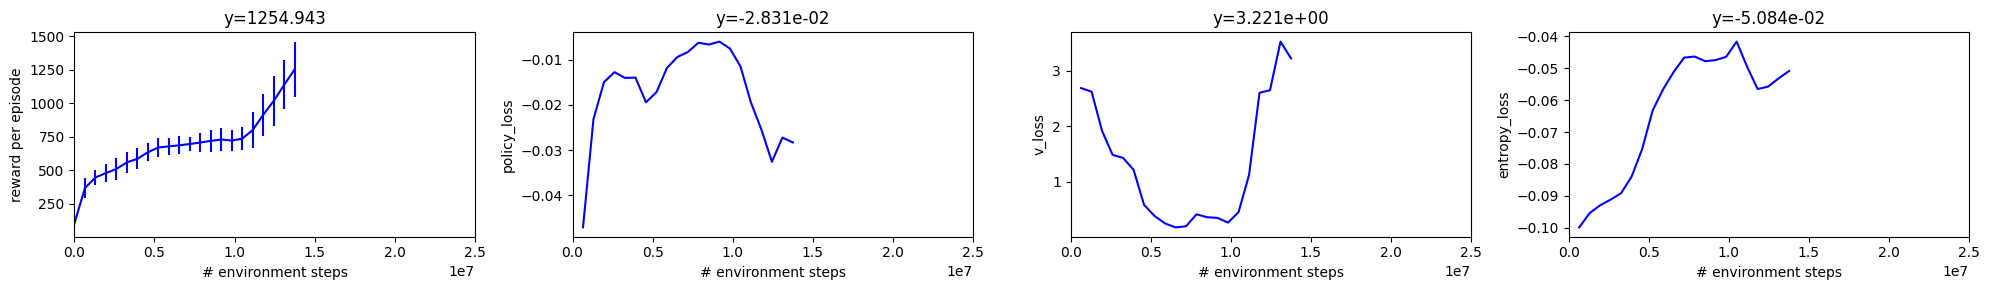

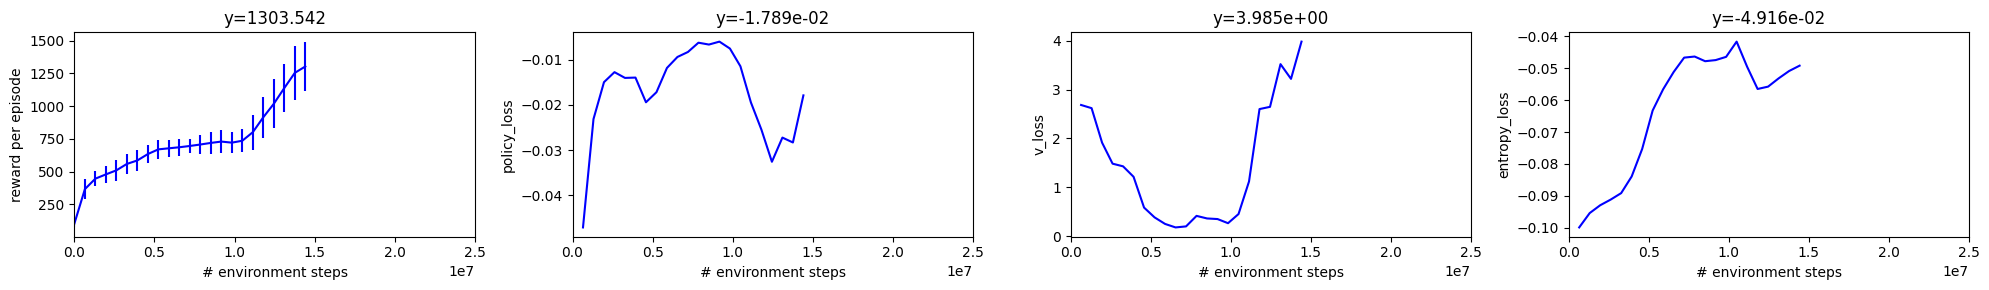

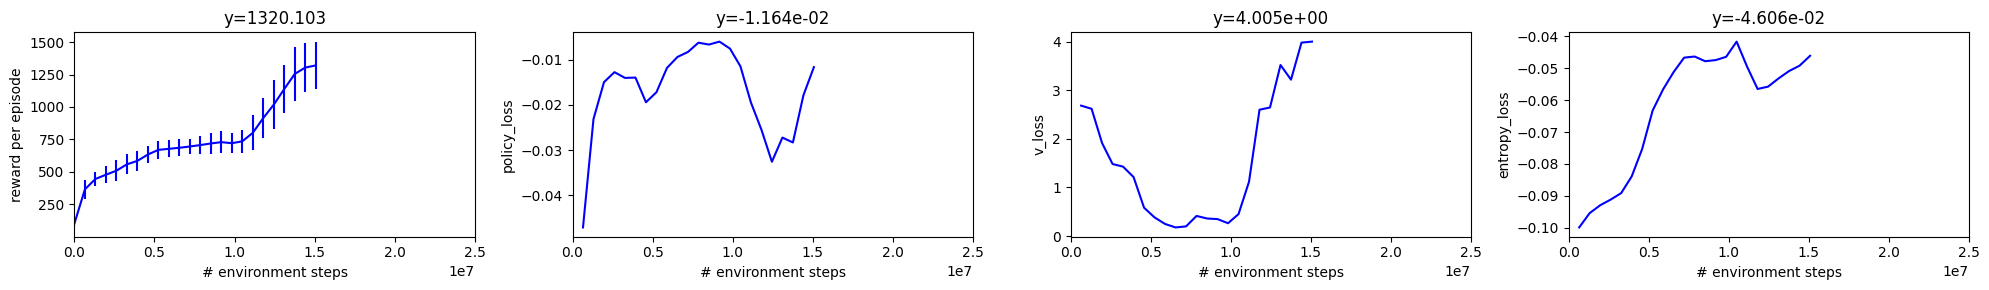

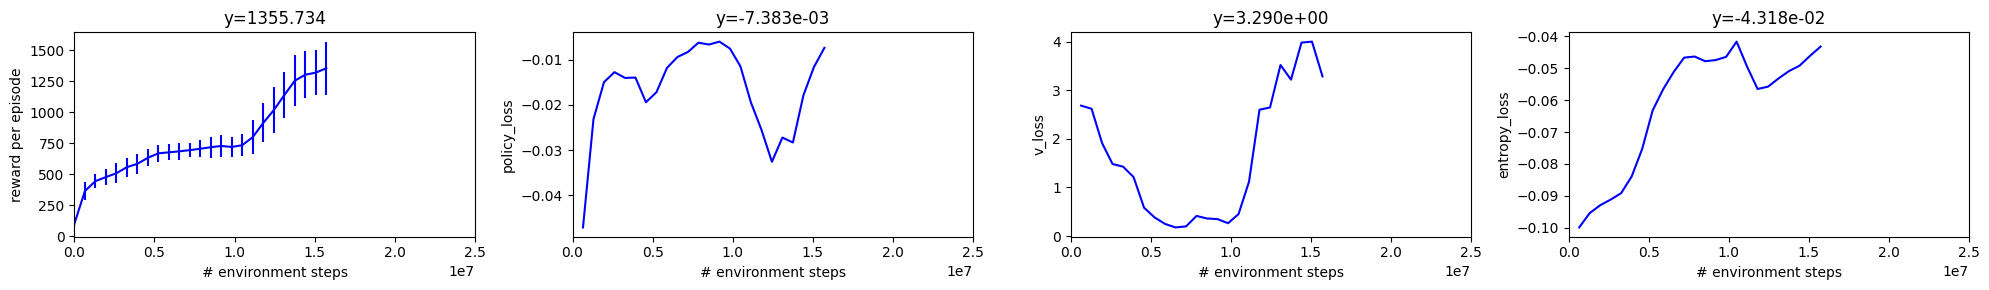

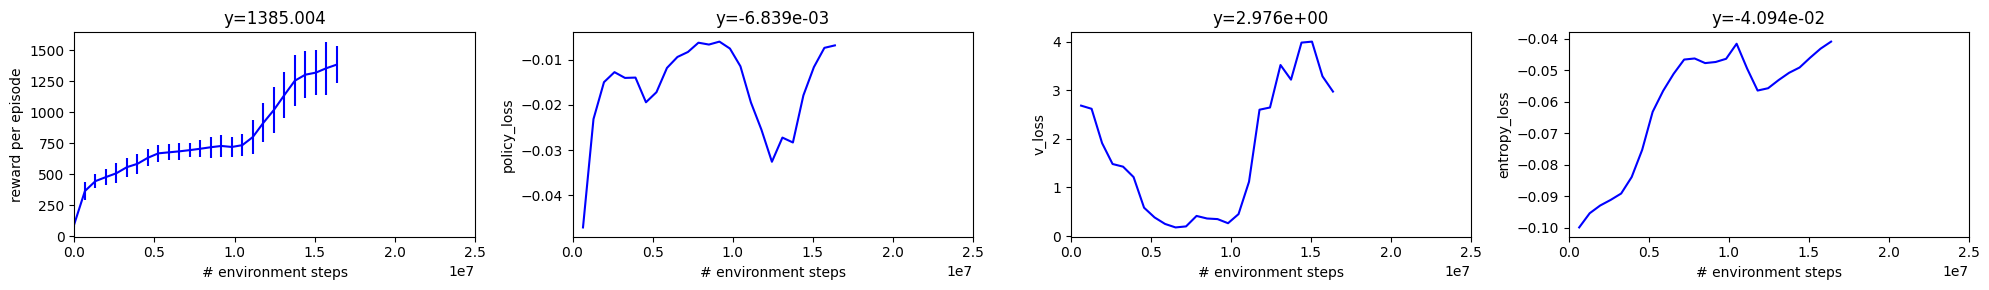

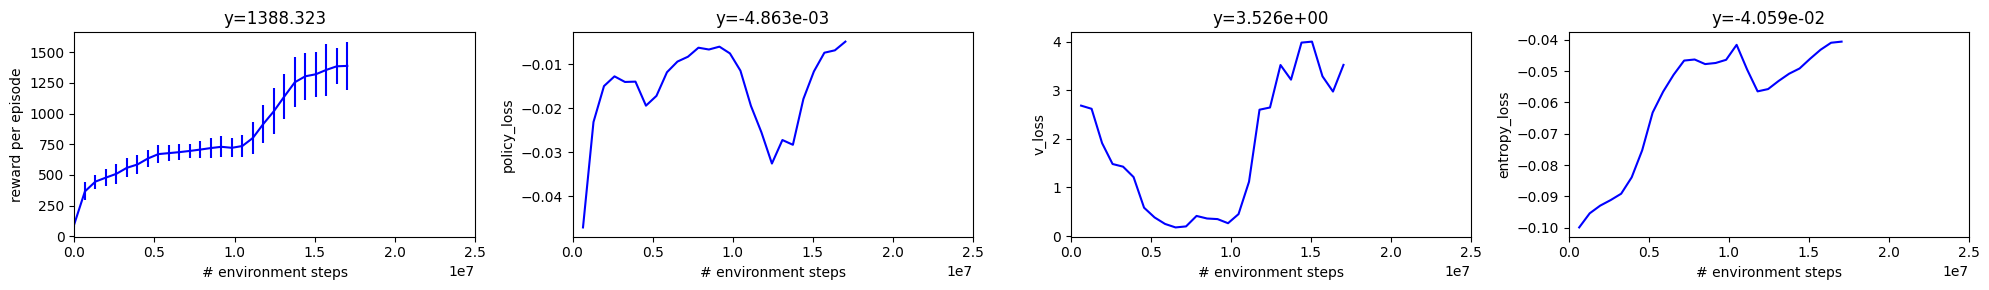

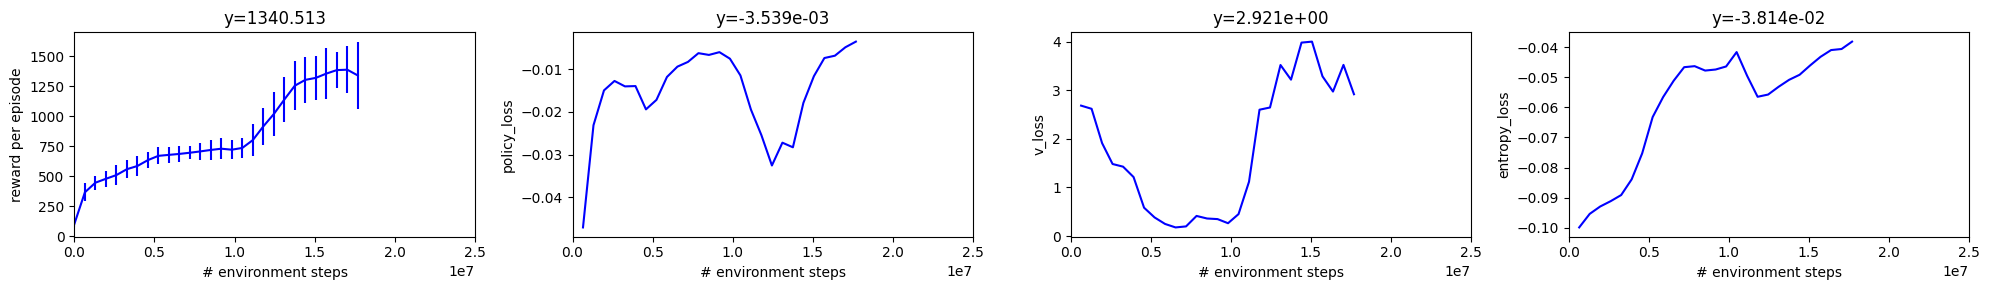

In [12]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

## Visualize Rollouts

In [12]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

While the above policy is very simple, the work was extended using the Madrona batch renderer, and policies were transferred on a real robot. We encourage folks to check out the Madrona-MJX tutorial notebooks ([part 1](https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/training_vision_1.ipynb) and [part 2](https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/training_vision_2.ipynb))!

# Dexterous Manipulation

Let's now train a policy that was transferred onto a real Leap Hand robot with the `LeapCubeReorient` environment! The environment contains a cube placed in the center of the hand, and the goal is to re-orient the cube in SO(3).

In [ ]:
env_name = 'LeapCubeReorient'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [ ]:
env_cfg

## Train Policy

Let's train an initial policy and visualize the rollouts. Notice that the PPO parameters contain `policy_obs_key` and `value_obs_key` fields, which allow us to train brax PPO with [asymmetric](https://arxiv.org/abs/1710.06542) observations for the actor and the critic. While the actor recieves proprioceptive state similar in nature to the real-world camera tracking sensors, the critic network recieves privileged state only available in the simulator. This enables more sample efficient learning, and we are able to train an initial policy in 33 minutes on a single RTX 4090.

Depending on the GPU device and topology, training can be brought down to 10-20 minutes as shown in the MuJoCo Playground technical report.

In [ ]:
from mujoco_playground.config import manipulation_params
ppo_params = manipulation_params.brax_ppo_config(env_name)
ppo_params

### PPO

In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    seed=1
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

## Visualize Rollouts

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

The above policy solves the task, but may look a little bit jittery. To get robust sim-to-real transfer,  we retrained from previous checkpoints using a curriculum on the maximum torque to facilitate exploration early on in the curriculum, and to produce smoother actions for the final policy. More details can be found in the MuJoCo Playground technical report!

🙌 Thanks for stopping by The Playground!